In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

import utils
import matplotlib.pyplot as plt

import os
import random as rn
import numpy as np
from tqdm import tqdm

SEED = 7
os.environ["PYTHONHASHSEED"] = str(SEED)
rn.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
data_dir = 'data/'

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])

In [4]:
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

print('Train set: ', len(trainloader.dataset))
print('Valid set: ', len(validloader.dataset))

Train set:  2026
Valid set:  870


Training images


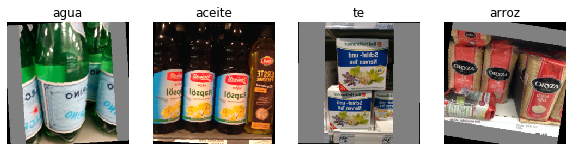

In [5]:
print('Training images')
images, labels = next(iter(trainloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    utils.imshow(images[ii], ax=ax, normalize=True, title=train_data.classes[labels[ii]])

Validation images


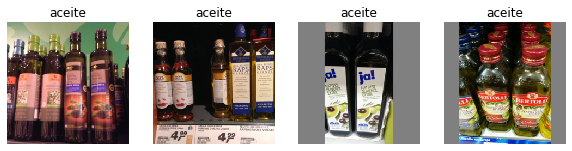

In [6]:
print('Validation images')
images, labels = next(iter(validloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    utils.imshow(images[ii], ax=ax, normalize=True, title=valid_data.classes[labels[ii]])

# TRAINING MODEL

In [7]:
### Load model (pretained on imagenet)
model = utils.ResNet18()

In [8]:
# Use device available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training using {}'.format(device))

epochs = 20
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00005) # 0.00005 0.00001 #0.000005

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
valid_loss_min = np.Inf

model.to(device)

for e in range(epochs):
    print('------------------------ EPOCH {} ------------------------'.format(e))
    # monitor loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # monitor accuracy
    train_accuracy = 0
    valid_accuracy = 0
    
    ###################
    # train the model #
    ###################
    print('Training')
    model.train() #train_mode
    for data, target in tqdm(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        equals = predicted == target
        
        train_accuracy += 100 * torch.mean(equals.type(torch.FloatTensor)).item()
        train_loss += loss.item()         
    
    ######################
    # validate the model #
    ######################
    print('Testing')
    with torch.no_grad():
        model.eval() #test_model        
        for data, target in validloader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            equals = predicted == target

            valid_accuracy += 100 * torch.mean(equals.type(torch.FloatTensor)).item()
            valid_loss += criterion(output,target).item()

    train_losses.append(train_loss/len(trainloader))
    valid_losses.append(valid_loss/len(validloader))
    
    train_accuracies.append(train_accuracy/len(trainloader))
    valid_accuracies.append(valid_accuracy/len(validloader))

    print('Train loss {:.3f}'.format(train_loss/len(trainloader)), "\t", 'Train accuracy {:.3f}'.format(train_accuracy/len(trainloader)))
    print('Valid loss {:.3f}'.format(valid_loss/len(validloader)), "\t", 'Valid accuracy {:.3f}'.format(valid_accuracy/len(validloader)))
    
    ###################
    # Save best model #
    ###################
    epoch_valid_loss = valid_loss/len(validloader)
    if epoch_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:6f} --> {:6f}). Saving model ...'.format(
        valid_loss_min,
        epoch_valid_loss))
        torch.save(model.state_dict(), 'models/ResNet18.pth')
        valid_loss_min = epoch_valid_loss

Training using cuda:0
------------------------ EPOCH 0 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:19<00:00,  1.64it/s]


Testing
Train loss 3.191 	 Train accuracy 10.407
Valid loss 2.547 	 Valid accuracy 31.890
Validation loss decreased (   inf --> 2.547146). Saving model ...
------------------------ EPOCH 1 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.83it/s]


Testing
Train loss 2.364 	 Train accuracy 33.203
Valid loss 2.024 	 Valid accuracy 48.672
Validation loss decreased (2.547146 --> 2.024368). Saving model ...
------------------------ EPOCH 2 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]


Testing
Train loss 1.825 	 Train accuracy 49.802
Valid loss 1.645 	 Valid accuracy 58.459
Validation loss decreased (2.024368 --> 1.645414). Saving model ...
------------------------ EPOCH 3 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]


Testing
Train loss 1.451 	 Train accuracy 62.337
Valid loss 1.392 	 Valid accuracy 64.791
Validation loss decreased (1.645414 --> 1.391680). Saving model ...
------------------------ EPOCH 4 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]


Testing
Train loss 1.151 	 Train accuracy 71.663
Valid loss 1.239 	 Valid accuracy 68.920
Validation loss decreased (1.391680 --> 1.238712). Saving model ...
------------------------ EPOCH 5 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.92it/s]


Testing
Train loss 0.946 	 Train accuracy 78.804
Valid loss 1.104 	 Valid accuracy 71.934
Validation loss decreased (1.238712 --> 1.104191). Saving model ...
------------------------ EPOCH 6 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.93it/s]


Testing
Train loss 0.777 	 Train accuracy 83.733
Valid loss 1.004 	 Valid accuracy 74.354
Validation loss decreased (1.104191 --> 1.004478). Saving model ...
------------------------ EPOCH 7 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.85it/s]


Testing
Train loss 0.618 	 Train accuracy 88.588
Valid loss 0.935 	 Valid accuracy 75.582
Validation loss decreased (1.004478 --> 0.934960). Saving model ...
------------------------ EPOCH 8 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]


Testing
Train loss 0.507 	 Train accuracy 90.276
Valid loss 0.876 	 Valid accuracy 76.028
Validation loss decreased (0.934960 --> 0.875931). Saving model ...
------------------------ EPOCH 9 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.85it/s]


Testing
Train loss 0.415 	 Train accuracy 93.869
Valid loss 0.828 	 Valid accuracy 77.590
Validation loss decreased (0.875931 --> 0.828421). Saving model ...
------------------------ EPOCH 10 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.87it/s]


Testing
Train loss 0.336 	 Train accuracy 95.775
Valid loss 0.797 	 Valid accuracy 78.336
Validation loss decreased (0.828421 --> 0.796957). Saving model ...
------------------------ EPOCH 11 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]


Testing
Train loss 0.274 	 Train accuracy 96.726
Valid loss 0.761 	 Valid accuracy 79.006
Validation loss decreased (0.796957 --> 0.760564). Saving model ...
------------------------ EPOCH 12 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.87it/s]


Testing
Train loss 0.232 	 Train accuracy 97.654
Valid loss 0.734 	 Valid accuracy 80.569
Validation loss decreased (0.760564 --> 0.733990). Saving model ...
------------------------ EPOCH 13 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.86it/s]


Testing
Train loss 0.183 	 Train accuracy 98.486
Valid loss 0.715 	 Valid accuracy 80.199
Validation loss decreased (0.733990 --> 0.714756). Saving model ...
------------------------ EPOCH 14 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.90it/s]


Testing
Train loss 0.154 	 Train accuracy 98.851
Valid loss 0.700 	 Valid accuracy 80.868
Validation loss decreased (0.714756 --> 0.700318). Saving model ...
------------------------ EPOCH 15 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.89it/s]


Testing
Train loss 0.131 	 Train accuracy 99.463
Valid loss 0.694 	 Valid accuracy 80.199
Validation loss decreased (0.700318 --> 0.693641). Saving model ...
------------------------ EPOCH 16 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.87it/s]


Testing
Train loss 0.122 	 Train accuracy 99.486
Valid loss 0.686 	 Valid accuracy 80.199
Validation loss decreased (0.693641 --> 0.686087). Saving model ...
------------------------ EPOCH 17 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.85it/s]


Testing
Train loss 0.092 	 Train accuracy 99.805
Valid loss 0.680 	 Valid accuracy 79.558
Validation loss decreased (0.686087 --> 0.679963). Saving model ...
------------------------ EPOCH 18 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.86it/s]


Testing
Train loss 0.084 	 Train accuracy 99.902
Valid loss 0.666 	 Valid accuracy 80.122
Validation loss decreased (0.679963 --> 0.666008). Saving model ...
------------------------ EPOCH 19 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.93it/s]


Testing
Train loss 0.074 	 Train accuracy 99.756
Valid loss 0.660 	 Valid accuracy 80.381
Validation loss decreased (0.666008 --> 0.659566). Saving model ...


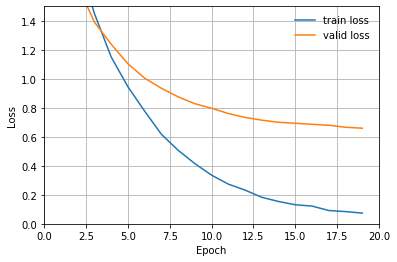

In [21]:
plt.plot(train_losses,label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend(frameon=False)
plt.xlim([0,epochs])
plt.ylim([0,1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.savefig('models/train_val_loss.jpg')
np.save('models/train_val_loss.npy',{'train_loss': train_losses, 'val_loss': valid_losses})

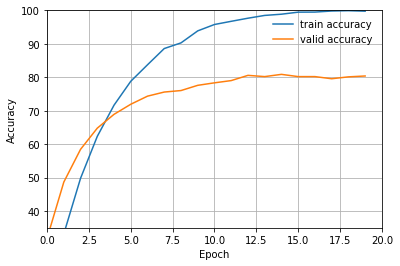

In [22]:
plt.plot(train_accuracies,label='train accuracy')
plt.plot(valid_accuracies, label='valid accuracy')
plt.legend(frameon=False)
plt.xlim([0,epochs])
plt.ylim([35,100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.savefig('models/train_val_acc.jpg')
np.save('models/train_val_acc.npy',{'train_acc': train_accuracies, 'val_acc': valid_accuracies})

In [16]:
torch.cuda.empty_cache()

# TESTING MODEL

In [23]:
def testing_model(data_dir, model_to_test):
    
    # Loading data and tranformations
    test_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])
    test_data = datasets.ImageFolder(data_dir, transform=test_transform)
    loader = torch.utils.data.DataLoader(test_data, batch_size=64)
    print('Test set: ', len(loader.dataset))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_to_test.to(device)
    
    pred=[]
    groundtruth=[]
    
    test_loss = 0.0
    test_accuracy = 0

    list_clases = loader.dataset.classes
    criterion = nn.NLLLoss()

    with torch.no_grad():
        model_to_test.eval() #test_model        
        for data, target in tqdm(loader):

            data, target = data.to(device), target.to(device)

            output = model_to_test(data)
            _, predicted = torch.max(output.data, 1)

            pred.extend(predicted.cpu().numpy())
            groundtruth.extend(target.cpu().numpy())

            equals = predicted == target

            test_accuracy += 100 * torch.mean(equals.type(torch.FloatTensor)).item()
            test_loss += criterion(output,target).item()

    print('loss {:.3f}'.format(test_loss/len(loader)), "\t", 'accuracy {:.3f}'.format(test_accuracy/len(loader)))
    
    groundtruth = [test_data.classes[k] for k in groundtruth]
    pred = [test_data.classes[k] for k in pred]
    
    from sklearn import metrics
    import seaborn as sns 
    
    print(metrics.classification_report(groundtruth, pred))
    
    print('Test Confusion Matrix')
    cm = metrics.confusion_matrix(groundtruth,pred,list(test_data.classes))
    
    plt.figure(figsize=(18,10))
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}, 
                fmt='g', cmap='Blues', xticklabels=list_clases, yticklabels=list_clases)
    plt.savefig('models/cm.jpg')
    plt.show()
    
    print('Test Normalized Confusion Matrix ')
    plt.figure(figsize=(18,10))
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2) # normalized
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}, 
                fmt='g', cmap='Blues', xticklabels=list_clases, yticklabels=list_clases)
    plt.savefig('models/cm_normalized.jpg')
    plt.show()
    return None
    

In [24]:
### Loading best model
best_model = utils.ResNet18(imagenet_weights=False)
best_model.load_state_dict(torch.load('models/ResNet18.pth'))

<All keys matched successfully>

Test set:  319


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.83it/s]


loss 0.612 	 accuracy 83.080
              precision    recall  f1-score   support

      aceite       0.78      0.78      0.78         9
        agua       1.00      0.94      0.97        17
       arroz       0.86      0.60      0.71        10
      azucar       0.88      0.88      0.88         8
        cafe       0.71      0.79      0.75        19
    caramelo       0.79      0.96      0.87        24
      cereal       0.79      0.83      0.81        18
       chips       1.00      0.75      0.86        12
   chocolate       0.77      0.85      0.81        20
    especias       0.69      0.69      0.69        13
    frijoles       0.88      0.78      0.82         9
     gaseosa       0.69      0.82      0.75        11
      harina       0.71      0.71      0.71         7
       jamon       0.87      0.81      0.84        16
        jugo       0.94      0.80      0.86        20
       leche       0.75      0.90      0.82        10
        maiz       1.00      1.00      1.00         

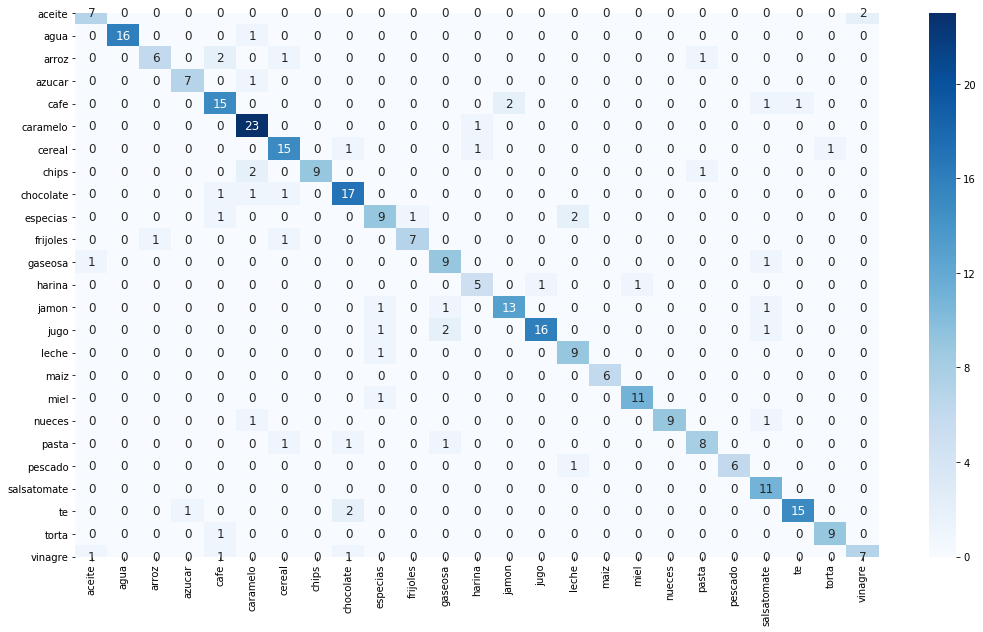

Test Normalized Confusion Matrix 


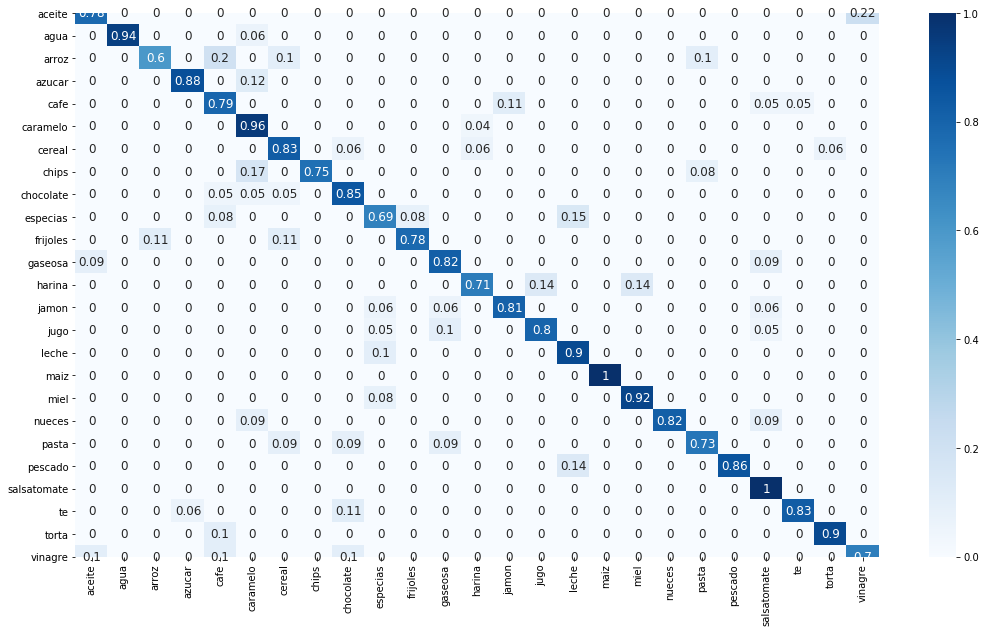

In [25]:
# Test model
test_dir = data_dir + '/test'
testing_model(test_dir, best_model)

In [20]:
torch.cuda.empty_cache()